In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputClassifier
%matplotlib inline

In [2]:
X = pd.read_csv('/kaggle/input/training/training_set_features.csv')
X

,respondent_id,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg


In [3]:
Y = pd.read_csv('/kaggle/input/training/training_set_labels.csv')
Y

,respondent_id,xyz_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0
...,...,...,...
26702,26702,0,0
26703,26703,0,0
26704,26704,0,1
26705,26705,0,0


In [4]:
Z = Y
Z.drop(['respondent_id'], axis = 1, inplace = True)
data = pd.concat([X,Z],axis=1)

In [5]:
data.isnull().sum()

respondent_id                      0
xyz_concern                       92
xyz_knowledge                    116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_xyz                 2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_xyz_vacc_effective       391
opinion_xyz_risk                 388
opinion_xyz_sick_from_vacc       395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [6]:
data.drop(['health_insurance', 'employment_industry', 'employment_occupation'], axis=1, inplace = True)

# EDA & cleaning

In [7]:
print(Y['xyz_vaccine'].value_counts())
print(Y['seasonal_vaccine'].value_counts())

xyz_vaccine
0    21033
1     5674
Name: count, dtype: int64
seasonal_vaccine
0    14272
1    12435
Name: count, dtype: int64


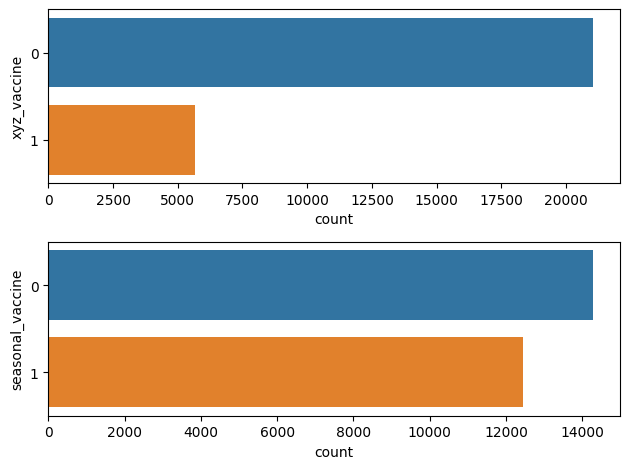

In [8]:
fig, ax = plt.subplots(2,1)

sns.countplot(Y, y='xyz_vaccine', ax=ax[0])
sns.countplot(Y, y='seasonal_vaccine', ax=ax[1])

plt.tight_layout()

In [9]:
data['hhs_geo_region'].unique()

array(['oxchjgsf', 'bhuqouqj', 'qufhixun', 'lrircsnp', 'atmpeygn',
       'lzgpxyit', 'fpwskwrf', 'mlyzmhmf', 'dqpwygqj', 'kbazzjca'],
      dtype=object)

In [10]:
non_numeric_col = data.select_dtypes(include='object').columns
data[non_numeric_col].head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City"
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City"
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City"
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City"


In [11]:
for col in data.columns:
    if data[col].isnull().sum() and data[col].dtypes != 'object':
        data.loc[(X[col].isnull()), col] = data[col].median()
for col in data.columns:
    if data[col].isnull().sum() and data[col].dtypes == 'object':
        data.loc[(data[col].isnull()), col] = data[col].mode().max()

In [12]:
data.isnull().sum()

respondent_id                  0
xyz_concern                    0
xyz_knowledge                  0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_xyz                0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
opinion_xyz_vacc_effective     0
opinion_xyz_risk               0
opinion_xyz_sick_from_vacc     0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_region                 0
census_msa

In [13]:
LE = LabelEncoder()
for col in non_numeric_col:
    data[col] = LE.fit_transform(data[col])

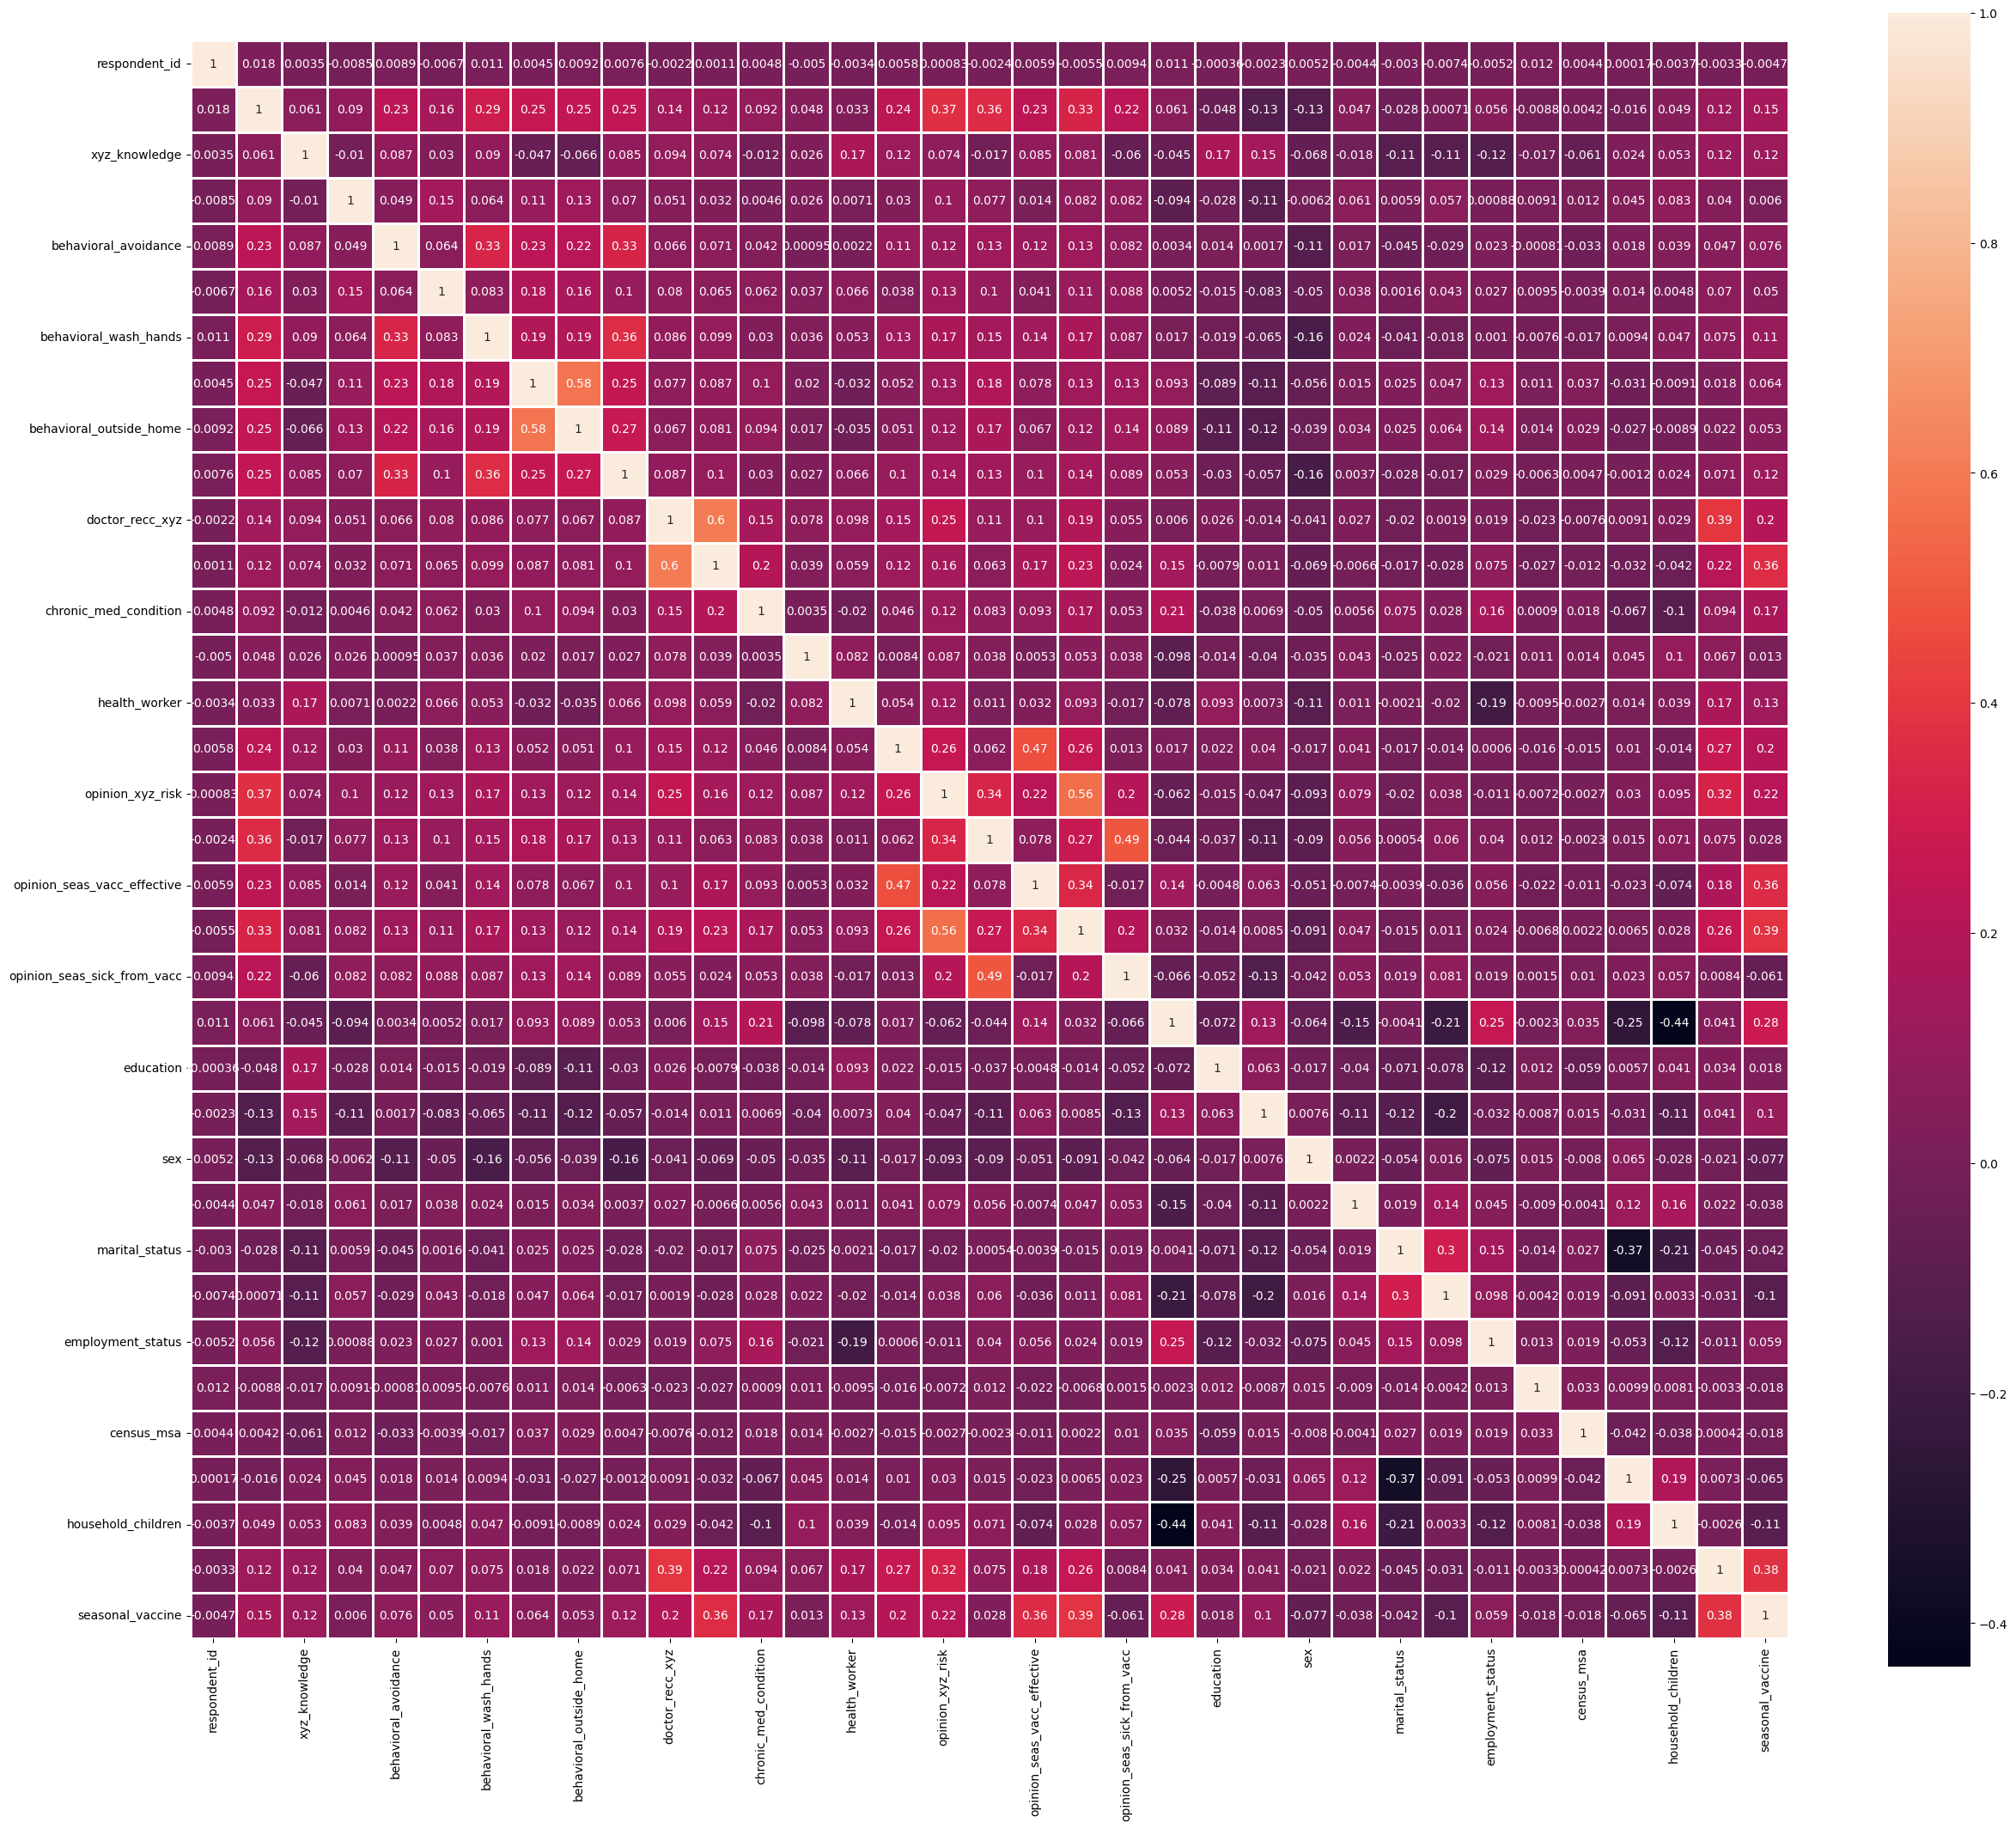

In [14]:
corr=data.corr()

g = sns.heatmap(corr, square=True, linewidths=1, annot=True)
g.figure.set_size_inches(30,25)
    
plt.show()

In [15]:
data['cleanliness'] =  data['behavioral_antiviral_meds']+ data['behavioral_avoidance']+\
                        data['behavioral_face_mask']+data['behavioral_wash_hands']+\
                       data['behavioral_large_gatherings'] + data['behavioral_outside_home']+\
                       data['behavioral_touch_face']

In [16]:
data['opinion'] = data['opinion_xyz_vacc_effective'] + data['opinion_xyz_risk']+\
                  data['opinion_xyz_sick_from_vacc'] + data['opinion_seas_vacc_effective']+\
                  data['opinion_seas_risk'] + data['opinion_seas_sick_from_vacc']

<Axes: xlabel='cleanliness', ylabel='opinion'>

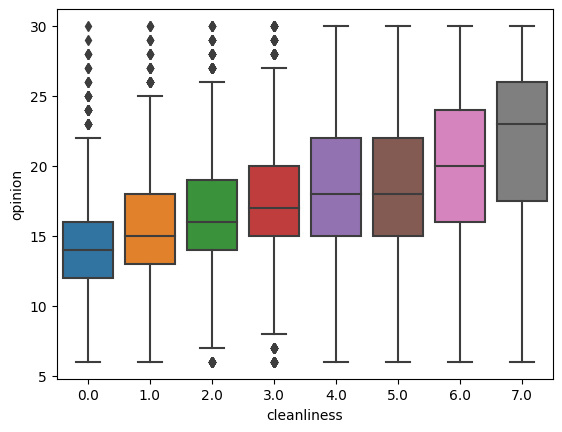

In [17]:
sns.boxplot(x='cleanliness', y='opinion', data=data)

In [18]:
data.drop(['race','child_under_6_months','opinion_xyz_sick_from_vacc','opinion_seas_sick_from_vacc','household_adults','behavioral_antiviral_meds','behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds','marital_status',
           'behavioral_avoidance','behavioral_face_mask','income_poverty','hhs_geo_region','employment_status','education','census_msa'],axis=1,inplace = True)
data.head()

,respondent_id,xyz_concern,xyz_knowledge,behavioral_wash_hands,behavioral_touch_face,doctor_recc_xyz,doctor_recc_seasonal,chronic_med_condition,health_worker,opinion_xyz_vacc_effective,...,opinion_seas_vacc_effective,opinion_seas_risk,age_group,sex,rent_or_own,household_children,xyz_vaccine,seasonal_vaccine,cleanliness,opinion
0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,...,2.0,1.0,3,0,0,0.0,0,0,2.0,11.0
1,1,3.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,...,4.0,2.0,1,1,1,0.0,0,1,4.0,23.0
2,2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,...,4.0,1.0,0,1,0,0.0,0,0,1.0,12.0
3,3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,5.0,4.0,4,0,1,0.0,0,1,3.0,21.0
4,4,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,...,3.0,1.0,2,0,0,0.0,0,0,4.0,16.0


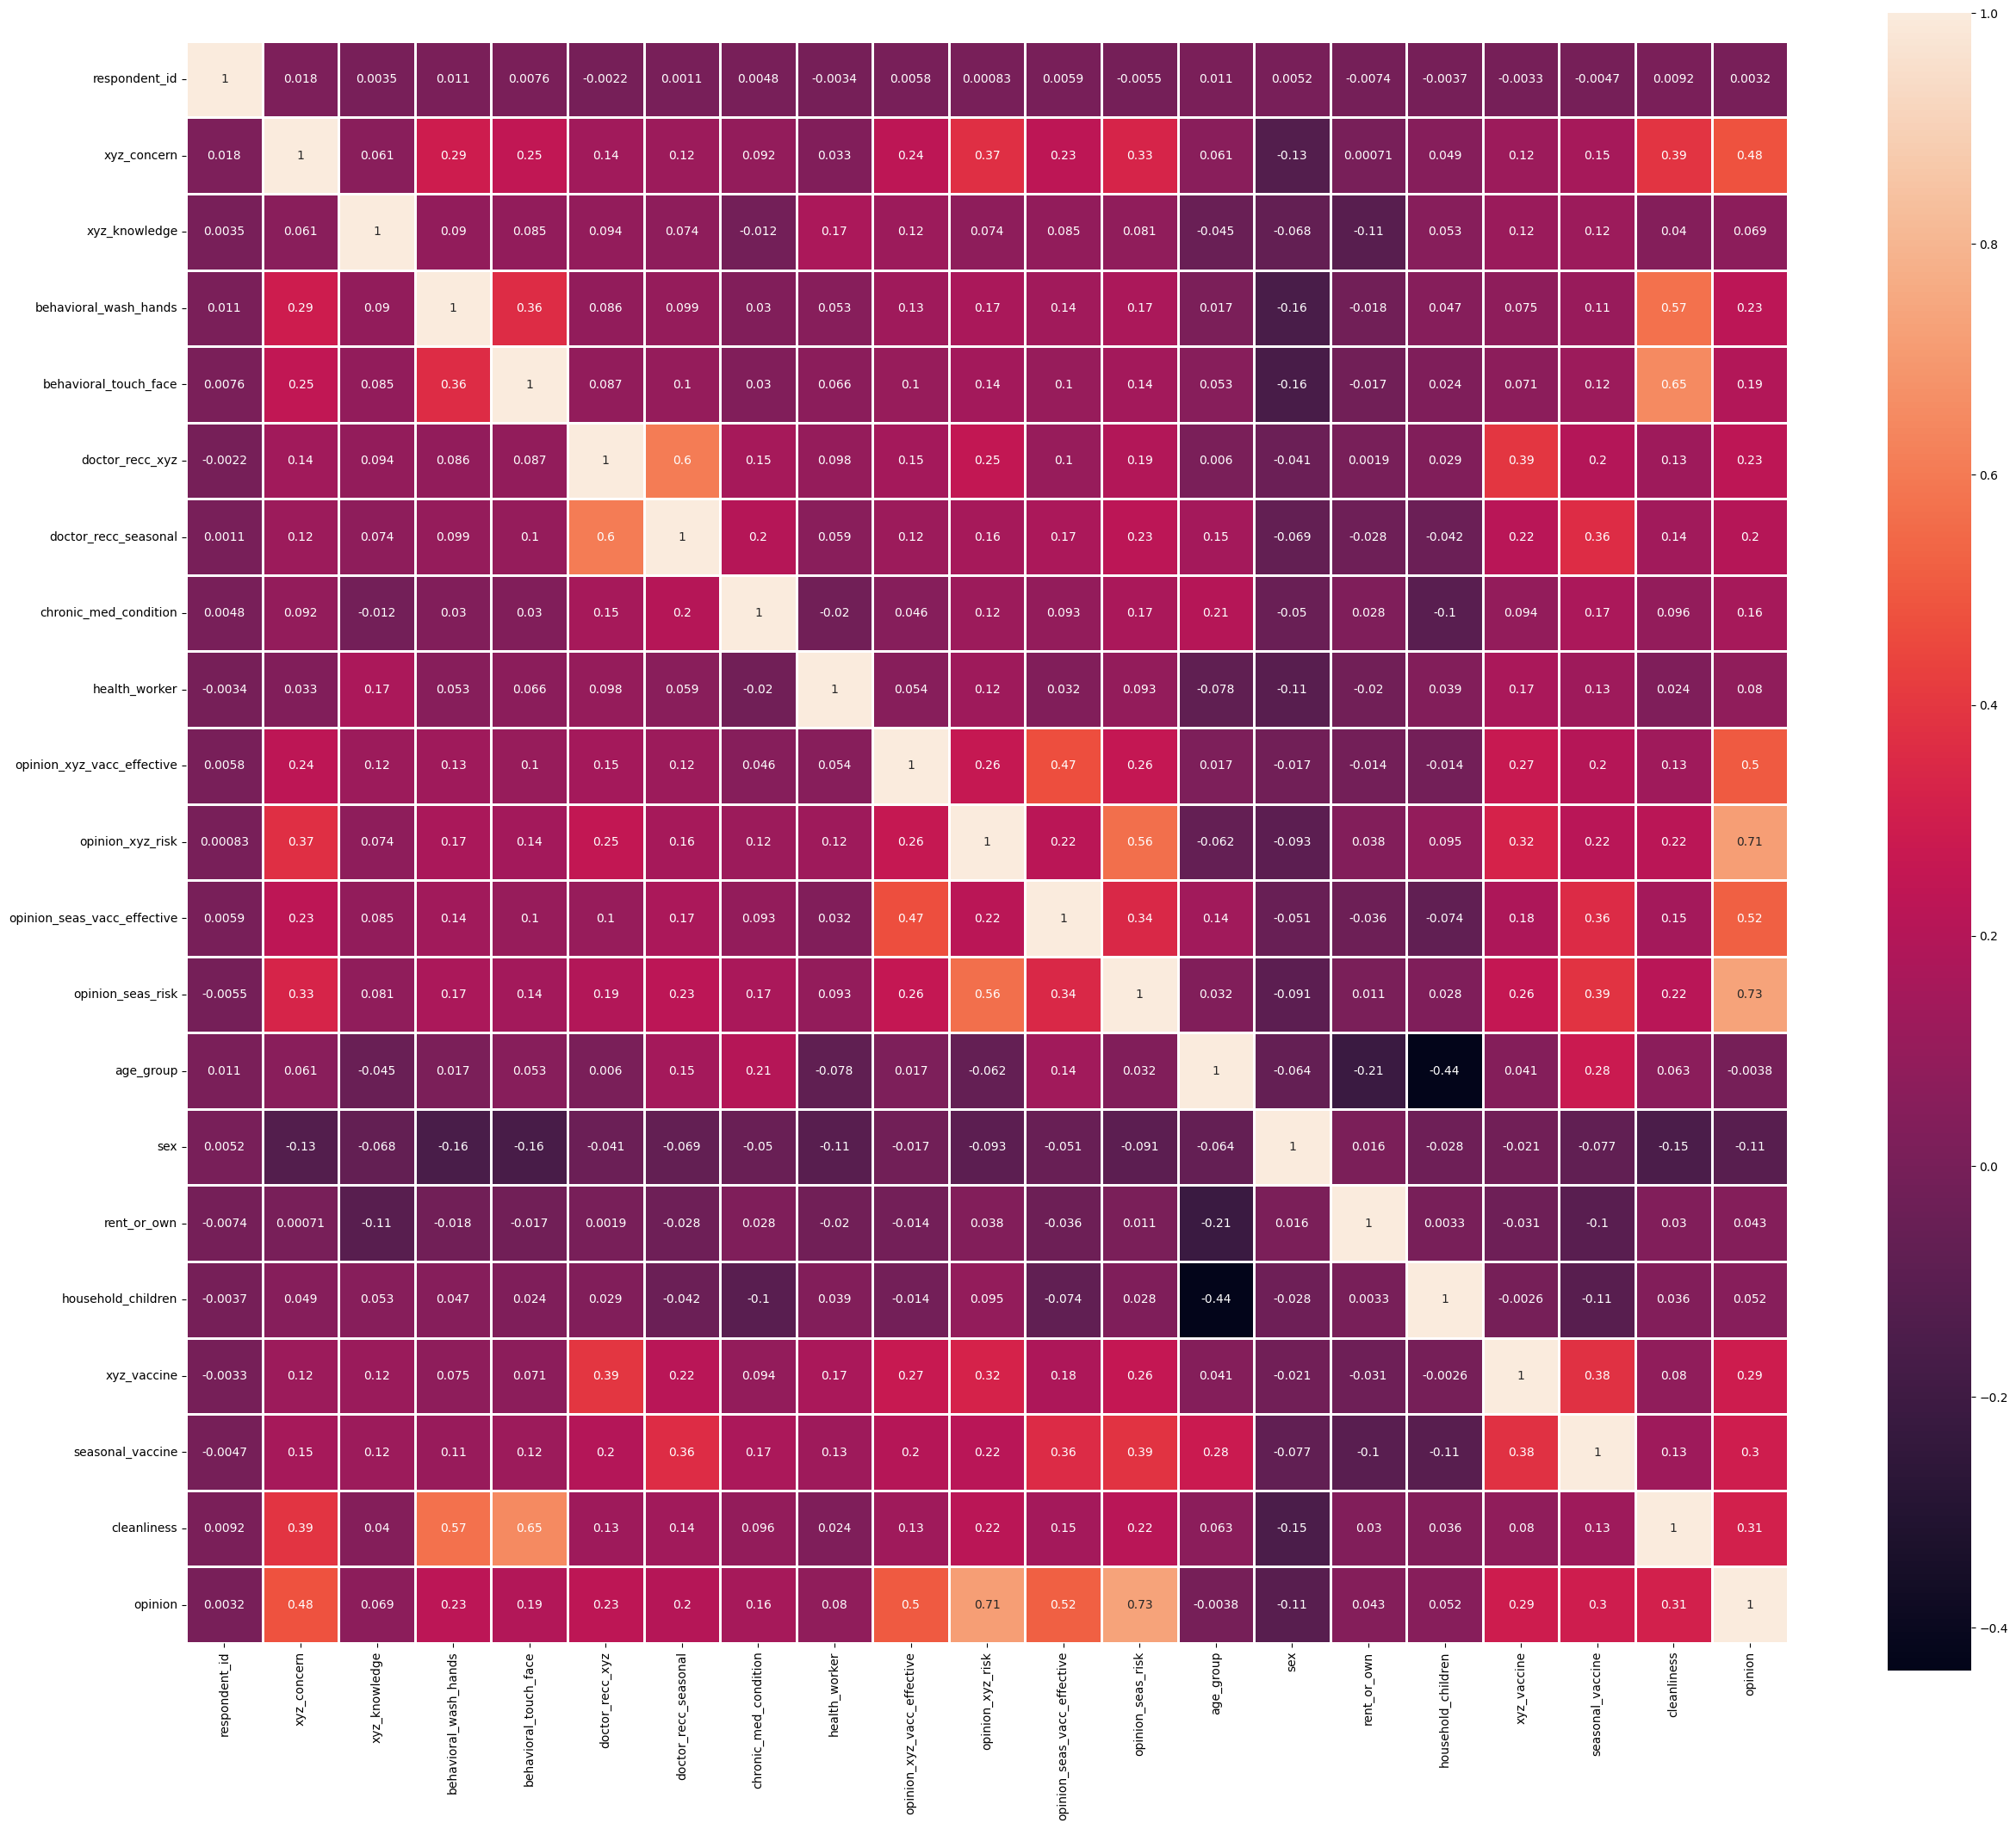

In [19]:
corr=data.corr()

g = sns.heatmap(corr, square=True, linewidths=1, annot=True)
g.figure.set_size_inches(30,25)
    
plt.show()

In [20]:
Y_label = Y[['xyz_vaccine', 'seasonal_vaccine']]

In [21]:
data.drop(['respondent_id','xyz_vaccine','seasonal_vaccine'],axis=1,inplace = True)
frames =[data,Y_label]
data = pd.concat(frames,axis=1)

data.head()

,xyz_concern,xyz_knowledge,behavioral_wash_hands,behavioral_touch_face,doctor_recc_xyz,doctor_recc_seasonal,chronic_med_condition,health_worker,opinion_xyz_vacc_effective,opinion_xyz_risk,opinion_seas_vacc_effective,opinion_seas_risk,age_group,sex,rent_or_own,household_children,cleanliness,opinion,xyz_vaccine,seasonal_vaccine
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,1.0,3,0,0,0.0,2.0,11.0,0,0
1,3.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,4.0,4.0,2.0,1,1,1,0.0,4.0,23.0,0,1
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,4.0,1.0,0,1,0,0.0,1.0,12.0,0,0
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,3.0,5.0,4.0,4,0,1,0.0,3.0,21.0,0,1
4,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,1.0,2,0,0,0.0,4.0,16.0,0,0


In [22]:
features = data.columns[:-2]
print(features)
labels = ['xyz_vaccine', 'seasonal_vaccine']

Index(['xyz_concern', 'xyz_knowledge', 'behavioral_wash_hands',
       'behavioral_touch_face', 'doctor_recc_xyz', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'opinion_xyz_vacc_effective',
       'opinion_xyz_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'age_group', 'sex', 'rent_or_own', 'household_children', 'cleanliness',
       'opinion'],
      dtype='object')


# Model

In [23]:
X_train, X_eval, y_train, y_eval = train_test_split(data[features], data[labels], test_size=0.2, shuffle=True)

In [24]:
X_train.columns

Index(['xyz_concern', 'xyz_knowledge', 'behavioral_wash_hands',
       'behavioral_touch_face', 'doctor_recc_xyz', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'opinion_xyz_vacc_effective',
       'opinion_xyz_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'age_group', 'sex', 'rent_or_own', 'household_children', 'cleanliness',
       'opinion'],
      dtype='object')

In [25]:
y_train

,xyz_vaccine,seasonal_vaccine
11867,0,1
6764,1,1
3088,1,1
26167,0,1
11234,0,0
...,...,...
23282,0,0
26070,0,0
7219,0,1
21583,0,1


In [26]:
def transform_test(Test_X):
    Test_X.drop(['respondent_id','health_insurance','employment_industry','employment_occupation'],axis=1,inplace = True)
            
    d = Test_X
    str_cols = d.select_dtypes(include = 'object').columns

    for col in Test_X.columns:
        if Test_X[col].isnull().sum() and Test_X[col].dtypes != 'object':
            Test_X.loc[(Test_X[col].isnull()), col] = Test_X[col].median()
    for col in Test_X.columns:
        if Test_X[col].isnull().sum() and Test_X[col].dtypes == 'object':
            Test_X.loc[(Test_X[col].isnull()), col] = Test_X[col].mode().max()

    LE = LabelEncoder()
    for col in str_cols:
        Test_X[col] = LE.fit_transform(Test_X[col]) 
            
    data = d

    data['cleanliness'] =  data['behavioral_antiviral_meds']+ data['behavioral_avoidance']+\
                        data['behavioral_face_mask']+data['behavioral_wash_hands']+\
                       data['behavioral_large_gatherings'] + data['behavioral_outside_home']+\
                       data['behavioral_touch_face']
    data['opinion'] = data['opinion_xyz_vacc_effective'] + data['opinion_xyz_risk']+\
                  data['opinion_xyz_sick_from_vacc'] + data['opinion_seas_vacc_effective']+\
                  data['opinion_seas_risk'] + data['opinion_seas_sick_from_vacc']

    data.drop(['race','child_under_6_months','opinion_xyz_sick_from_vacc','opinion_seas_sick_from_vacc','household_adults','behavioral_antiviral_meds','behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds','marital_status',
           'behavioral_avoidance','behavioral_face_mask','income_poverty','hhs_geo_region','employment_status','education','census_msa'],axis=1,inplace = True)
    
    Test_X = data
    return Test_X

In [27]:
Test_X = pd.read_csv('/kaggle/input/training/test_set_features.csv')
Test_X

,respondent_id,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
1,26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
2,26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
3,26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
4,26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26703,53410,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,dqpwygqj,"MSA, Principle City",1.0,1.0,NaN,NaN
26704,53411,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,Below Poverty,Married,Rent,Employed,qufhixun,Non-MSA,1.0,3.0,fcxhlnwr,vlluhbov
26705,53412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,qufhixun,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26706,53413,3.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,bhuqouqj,"MSA, Not Principle City",1.0,0.0,NaN,NaN


In [28]:
Test_X = transform_test(Test_X)
Test_X.isnull().sum()

xyz_concern                    0
xyz_knowledge                  0
behavioral_wash_hands          0
behavioral_touch_face          0
doctor_recc_xyz                0
doctor_recc_seasonal           0
chronic_med_condition          0
health_worker                  0
opinion_xyz_vacc_effective     0
opinion_xyz_risk               0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
age_group                      0
sex                            0
rent_or_own                    0
household_children             0
cleanliness                    0
opinion                        0
dtype: int64

In [29]:
Test_X.columns

Index(['xyz_concern', 'xyz_knowledge', 'behavioral_wash_hands',
       'behavioral_touch_face', 'doctor_recc_xyz', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'opinion_xyz_vacc_effective',
       'opinion_xyz_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'age_group', 'sex', 'rent_or_own', 'household_children', 'cleanliness',
       'opinion'],
      dtype='object')

In [30]:
estimators=MultiOutputClassifier(
    estimator=LogisticRegression()
)

pipe = make_pipeline(StandardScaler(), estimators)

In [31]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=LogisticRegression()))])

In [32]:
pred = pipe.predict_proba(X_eval)
pred

[array([[0.90349284, 0.09650716],
        [0.88426968, 0.11573032],
        [0.63303026, 0.36696974],
        ...,
        [0.55933764, 0.44066236],
        [0.75159859, 0.24840141],
        [0.93058786, 0.06941214]]),
 array([[0.83997936, 0.16002064],
        [0.27259307, 0.72740693],
        [0.03948326, 0.96051674],
        ...,
        [0.21215982, 0.78784018],
        [0.1875186 , 0.8124814 ],
        [0.80769923, 0.19230077]])]

In [33]:
y_preds = pd.DataFrame(
    {
        "xyz_vaccine": pred[0][:, 1],
        "seasonal_vaccine": pred[1][:, 1],
    },
    index = y_eval.index
)
print(y_preds.shape)
y_preds.head()

(5342, 2)


,xyz_vaccine,seasonal_vaccine
1381,0.096507,0.160021
11494,0.115730,0.727407
11645,0.366970,0.960517
1304,0.187116,0.927502
17635,0.753292,0.984272


In [34]:
print(roc_auc_score(y_eval, y_preds))

0.8282612710707028


In [35]:
test_pred = pipe.predict_proba(Test_X)
test_pred

[array([[0.90429409, 0.09570591],
        [0.94991057, 0.05008943],
        [0.58109364, 0.41890636],
        ...,
        [0.87471471, 0.12528529],
        [0.96318309, 0.03681691],
        [0.4515947 , 0.5484053 ]]),
 array([[0.76601317, 0.23398683],
        [0.93000666, 0.06999334],
        [0.27203037, 0.72796963],
        ...,
        [0.81147328, 0.18852672],
        [0.64719017, 0.35280983],
        [0.4753114 , 0.5246886 ]])]

In [36]:
submission_df = pd.read_csv('/kaggle/input/training/submission_format.csv')

In [37]:
submission_df["h1n1_vaccine"] = test_pred[0][:, 1]
submission_df["seasonal_vaccine"] = test_pred[1][:, 1]

submission_df.head()


,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.095706,0.233987
1,26708,0.050089,0.069993
2,26709,0.418906,0.727970
3,26710,0.495529,0.877261
4,26711,0.242472,0.518235


In [38]:
submission_df.to_csv('my_submission.csv',index=False)